In [1]:
# this is a python notebook written by I. Achitouv Sept. 2024 that can be used to reproduce the results of arXiv:XXX.XXX
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import pandas as pd
import numpy as np
from scipy.stats import poisson
from scipy import stats
import math
from numpy import linalg as LA
pd.core.common.is_list_like = pd.api.types.is_list_like
#import pandas_datareader as web
import seaborn as sns
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import minimize
from random import sample
plt.style.use('fivethirtyeight')
#import yfinance as yf  
from yahoo_fin.stock_info import get_data
from scipy.stats import kurtosis
from scipy.stats import skew
import yfinance as yf

import random
import requests
import pandas as pd
from bs4 import BeautifulSoup
import graphviz
import re
import pydot #https://github.com/pydot/pydot
from scipy.stats import kurtosis
from scipy.stats import skew


from functions_RDW import *

In [2]:
# read the data or download the data by changing download=1
start, end = '2019-01-01', '2024-01-01'
download=0
df,dic_sector=read_downloaddata(download,start,end)


Time=len(df)
Nstocks=df.columns
labstocks=list(df.columns.values)
dicstocks={}
for i in range(len(labstocks)):
    dicstocks[i]=labstocks[i]
Nstocks=len(df.columns)
print('Time=',Time,'Nstock=',Nstocks)
Stocks=np.array(df)
Q=Time/Nstocks
print('Q=',Q)

Time= 1258 Nstock= 485
Q= 2.593814432989691


**********
0.010000001460365724
Beta= -0.99 nb of lambda= 484 Lcut= 0.05000020583633776 Tc= 0.049999992698172444 a0= 0.001
**********
0.013239036647820189
Beta= -0.9 nb of lambda= 484 Lcut= 0.2500237409780982 Tc= 0.0377670984151498 a0= 0.001
**********
0.02089841368875665
Beta= -0.8 nb of lambda= 480 Lcut= 0.25011132393233937 Tc= 0.023925260904802553 a0= 0.001
**********
0.06368081641985363
Beta= -0.7 nb of lambda= 477 Lcut= 0.40029219067822686 Tc= 0.0078516581305028 a0= 0.001
**********
0.08981268777669613
Beta= -0.6 nb of lambda= 471 Lcut= 0.5005974610757286 Tc= 0.005567142153045953 a0= 0.001
**********
0.12736840620836312
Beta= -0.5 nb of lambda= 472 Lcut= 0.9510443372525806 Tc= 0.003925620292225731 a0= 0.001
**********
0.1873598700250476
Beta= -0.4 nb of lambda= 470 Lcut= 1.2516080395912124 Tc= 0.0026686611168824812 a0= 0.001
**********
0.2728140847361221
Beta= -0.3 nb of lambda= 459 Lcut= 1.1021975052627797 Tc= 0.001832749949415633 a0= 0.001
**********
0.33840288914426536
Beta= -0

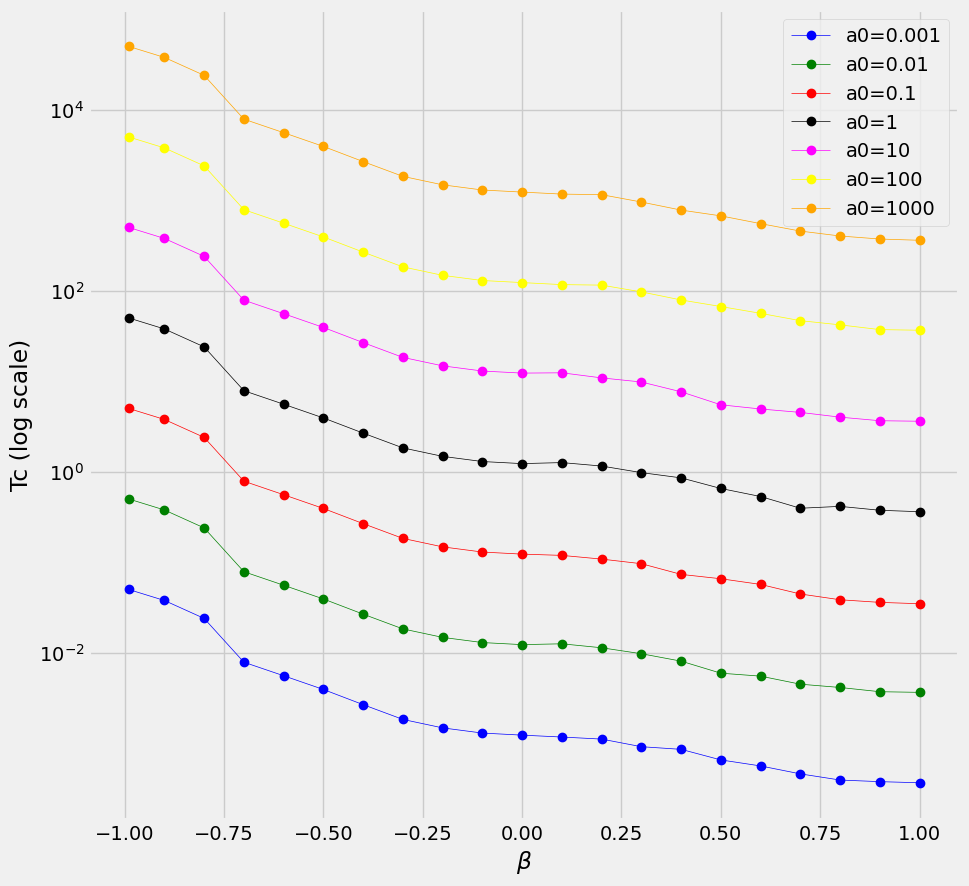

In [3]:
#### Fig1: Tc as function of beta and a0

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
colors = ['blue', 'green', 'red', 'black', 'magenta', 'yellow', 
           'orange', 'purple', 'brown', 'gray', 'olive', 'navy']
ic=0
for a0 in [0.001,0.01,0.1,1,10,100,1000]:
    Tc_var,beta_var=findTc_beta(a0,Stocks)
    ax.plot(beta_var,Tc_var,label='a0='+str(a0),marker='o',alpha=1,lw=0.5,color=colors[ic])
    ic+=1


ax.legend()
ax.set_ylabel('Tc (log scale)')
ax.set_yscale('log')
ax.set_xlabel(r'$\beta$')
fig.savefig('Tc_beta_a0.png')

sig_r= 1.0
sig_r= 0.9973047915953934
sig_r= 1.0
sig_r= 0.9155019250177084
sig_r= 1.0
sig_r= 0.761355317766384
sig_r= 1.0
sig_r= 0.3286924586465827


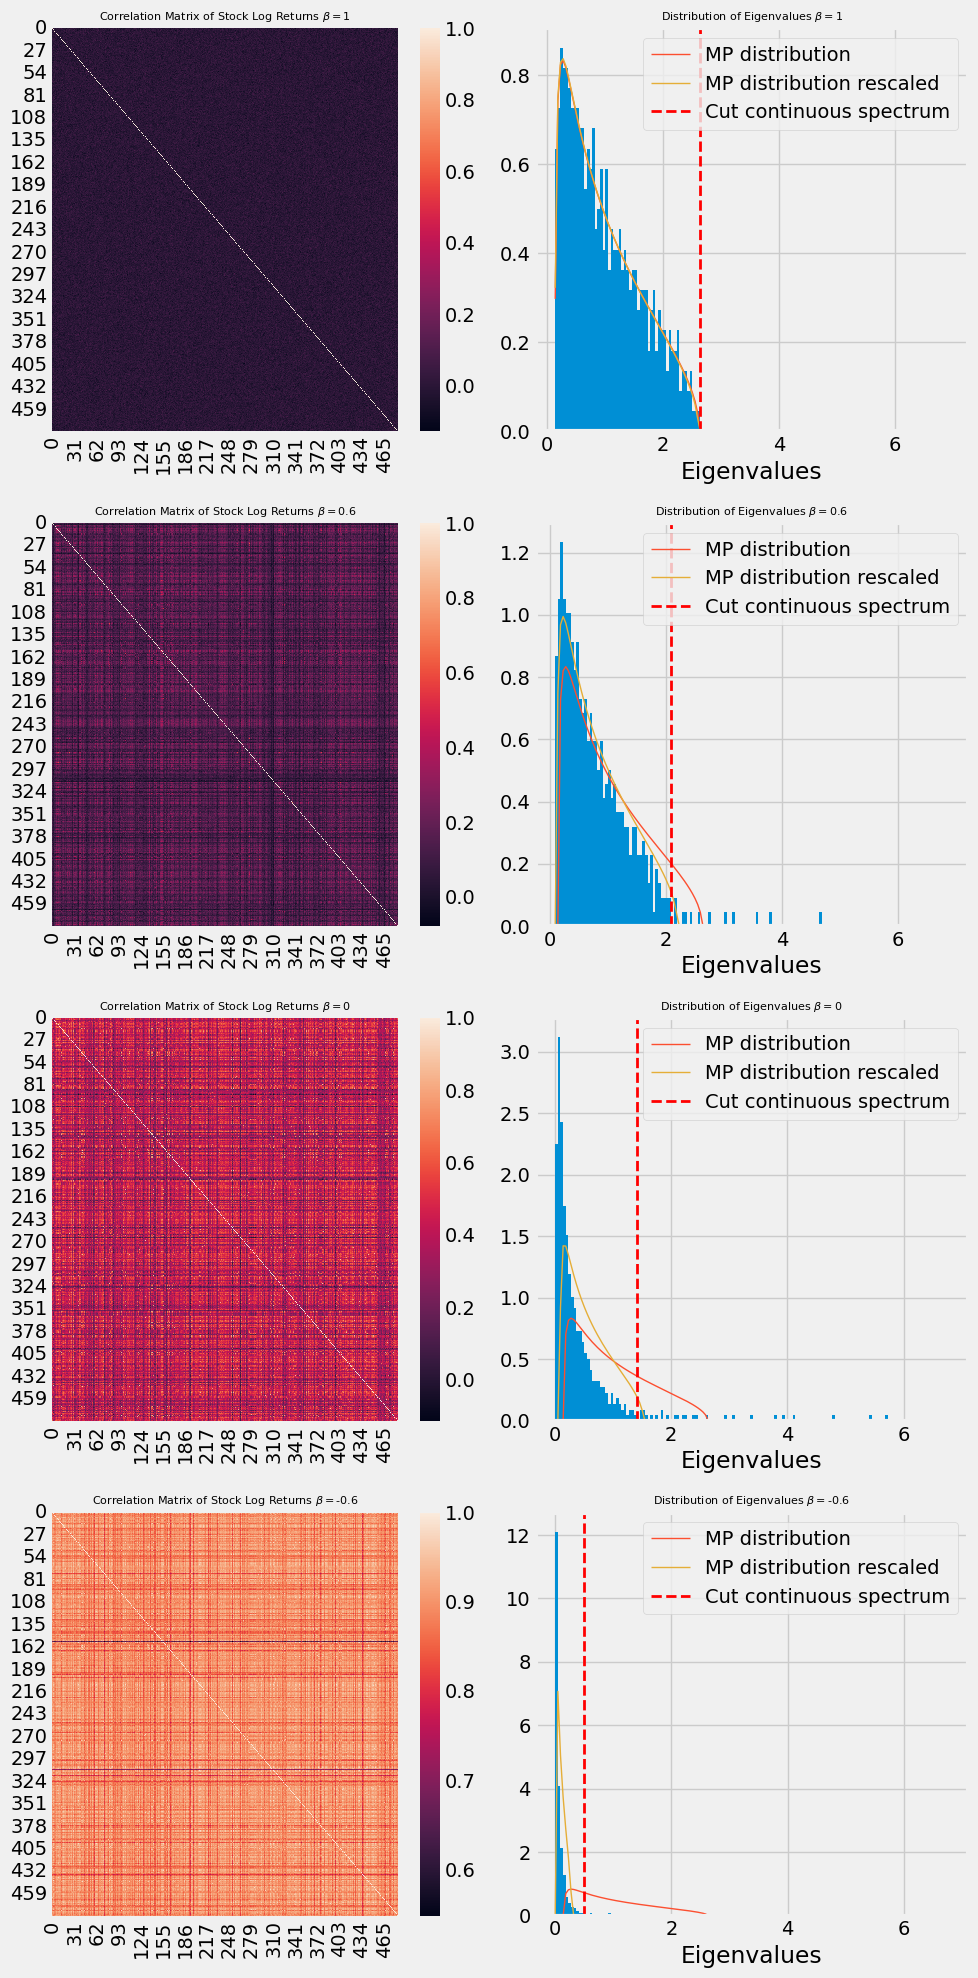

In [4]:
# look in details at pdf of the eigenvalues for some cases:

Beta_values = [1,0.6, 0, -0.6]  


fig, axs = plt.subplots(nrows=len(Beta_values), ncols=2, figsize=(10, 5 * len(Beta_values)))  # Adjust height per Beta

binss = 1. / np.sqrt(Nstocks)

for i, Beta in enumerate(Beta_values):
    # Compute correlation matrix and eigenvalues
    Stocks_b = Stocks_beta(Beta, Stocks)
    CorrMtest, Rettest = computeCorrM(Stocks_b)
    eigenvalues, _ = LA.eig(CorrMtest)
    eigenvalues = np.sort(eigenvalues)  # Sort eigenvalues

    # Compute Lcut
    counts, bin_edges = np.histogram(eigenvalues, bins=[min(eigenvalues) + i * binss for i in range(150)])
    Lcut = bin_edges[np.argmax(counts < 1)]  # Largest eigenvalue of continuous spectrum

    # Plot histogram of eigenvalues
    ax_hist = axs[i, 1]  # Right side (2nd column)
    ax_hist.hist(eigenvalues, bins=[min(eigenvalues) + i * binss for i in range(150)], density=True)

    # Plot Marchenko-Pastur distribution
    sig_r = 1.0
    Lmin, Lmax, Pdf = MarchenkoPastur(Q, bin_edges, sig_r)
    ax_hist.plot(bin_edges, Pdf, lw=1, label='MP distribution')

    # Plot Marchenko-Pastur distribution rescaled 
    sig_r =np.sqrt(1-sum(eigenvalues[-1:]/Nstocks))
    Lmin, Lmax, Pdf = MarchenkoPastur(Q, bin_edges, sig_r)
    ax_hist.plot(bin_edges, Pdf, lw=1, label='MP distribution rescaled')

    # Add vertical line for Lcut
    ax_hist.axvline(x=Lcut, color='r', linestyle='--', linewidth=2, label=r'Cut continuous spectrum')
    ax_hist.legend()
    ax_hist.set_xlabel('Eigenvalues')
    ax_hist.set_title(r'Distribution of Eigenvalues $\beta=$' + str(Beta), fontsize=8)

    # Plot correlation matrix as heatmap
    ax_heatmap = axs[i, 0]  # Left side (1st column)
    sns.heatmap(CorrMtest, ax=ax_heatmap, fmt='.1g', annot=False)
    ax_heatmap.set_title(r'Correlation Matrix of Stock Log Returns $\beta=$' + str(Beta), fontsize=8)

plt.tight_layout()
plt.savefig('Correlation_Eigenvalues_Beta_Variation.png')
plt.show()


In [4]:
binss=1./np.sqrt(Nstocks) #0.0005
print('binss',binss)
a0=2
#choose values of beta ! for completely correlated walks beta=-1 there is numerical instabilities here we stop at beta>=-0.6
Betavalues=[-0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.05, 0.1, 0.15, 0.2, 0.5, 1]
for Beta in Betavalues:
    for ToverTc in [0.1,10]: # choose values of T/Tc
        make_qmu_averaged_realisation(Beta,a0,ToverTc,Stocks,binss)

binss 0.045407660918649985
Lcut= 0.5000817311808784
Nbulk= 471
nb of lambda= 471 Lcut= 0.5000817311808784 nb lambdaall= 485
Lmax= 1671.749531002366
0.09031324324148055
Tc= 11.072573236310305
Lcut= 0.5000817311808784
Nbulk= 471
nb of lambda= 471 Lcut= 0.5000817311808784 nb lambdaall= 485
Lmax= 1671.749531002366
0.09031324324148055
Tc= 11.072573236310305
Lcut= 0.7275669119509803
Nbulk= 468
nb of lambda= 468 Lcut= 0.7275669119509803 nb lambdaall= 485
Lmax= 956.1706378168192
0.1456438803033362
Tc= 6.8660626036416685
Lcut= 0.7275669119509803
Nbulk= 468
nb of lambda= 468 Lcut= 0.7275669119509803 nb lambdaall= 485
Lmax= 956.1706378168192
0.1456438803033362
Tc= 6.8660626036416685
Lcut= 0.8189459361269122
Nbulk= 459
nb of lambda= 459 Lcut= 0.8189459361269122 nb lambdaall= 485
Lmax= 620.6541539971454
0.2002580481198298
Tc= 4.99355710988266
Lcut= 0.8189459361269122
Nbulk= 459
nb of lambda= 459 Lcut= 0.8189459361269122 nb lambdaall= 485
Lmax= 620.6541539971454
0.2002580481198298
Tc= 4.993557109882

In [5]:
# Define the model function to fit a and b 
def model(t, a, b):
    return (np.exp(-a * t) / t**b)
    
# Initialize for imu values
imu_list = [0, 1,2, 50,250]  # Define the list of imu values

# Initialize dictionaries to store results for each imu
dic_beta_aTc01 = {}
dic_beta_aTc10 = {}

dic_beta_bTc01 = {}
dic_beta_bTc10 = {}
# Create a nested dictionary structure for each imu
for imu in imu_list:
    dic_beta_aTc01[imu] = {}
    dic_beta_aTc10[imu] = {}
    
    dic_beta_bTc01[imu] = {}
    dic_beta_bTc10[imu] = {}



# Loop through Betas and ToverTc values
for Beta in [-0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.05, 0.1, 0.15, 0.2, 0.5, 1]:
    for ToverTc in [0.1, 10]:
        dfmu = read_qmu_averaged_realisation(Beta, a0, ToverTc, Stocks)  # Read the data
        
        # Loop through each imu in imu_list
        for imu in imu_list:
            l = dfmu[str(imu)].iloc[:30].tolist()  # Extract data for the given imu
            t = np.arange(0.0001, len(l))  # Create time array
            initial_guess = [0.1, 0.1]  # Initial guess for curve fitting

            # Perform the curve fitting
            params, covariance = curve_fit(model, t, l, p0=initial_guess)
            a_fitted, b_fitted = params  # Extract fitted parameters
            
            # Predicted values based on the fitted parameters
            l_pred = model(t, *params)

            # Calculate goodness of fit metrics (optional for analysis)
            r2 = r2_score(l, l_pred)  
            rmse = np.sqrt(mean_squared_error(l, l_pred))
            mae = mean_absolute_error(l, l_pred)
            
            # Store the fitted parameters in the corresponding dictionary
            if ToverTc == 0.1:
                dic_beta_aTc01[imu][Beta] = a_fitted
                dic_beta_bTc01[imu][Beta] = b_fitted
            else:
                dic_beta_aTc10[imu][Beta] = a_fitted
                dic_beta_bTc10[imu][Beta] = b_fitted

            

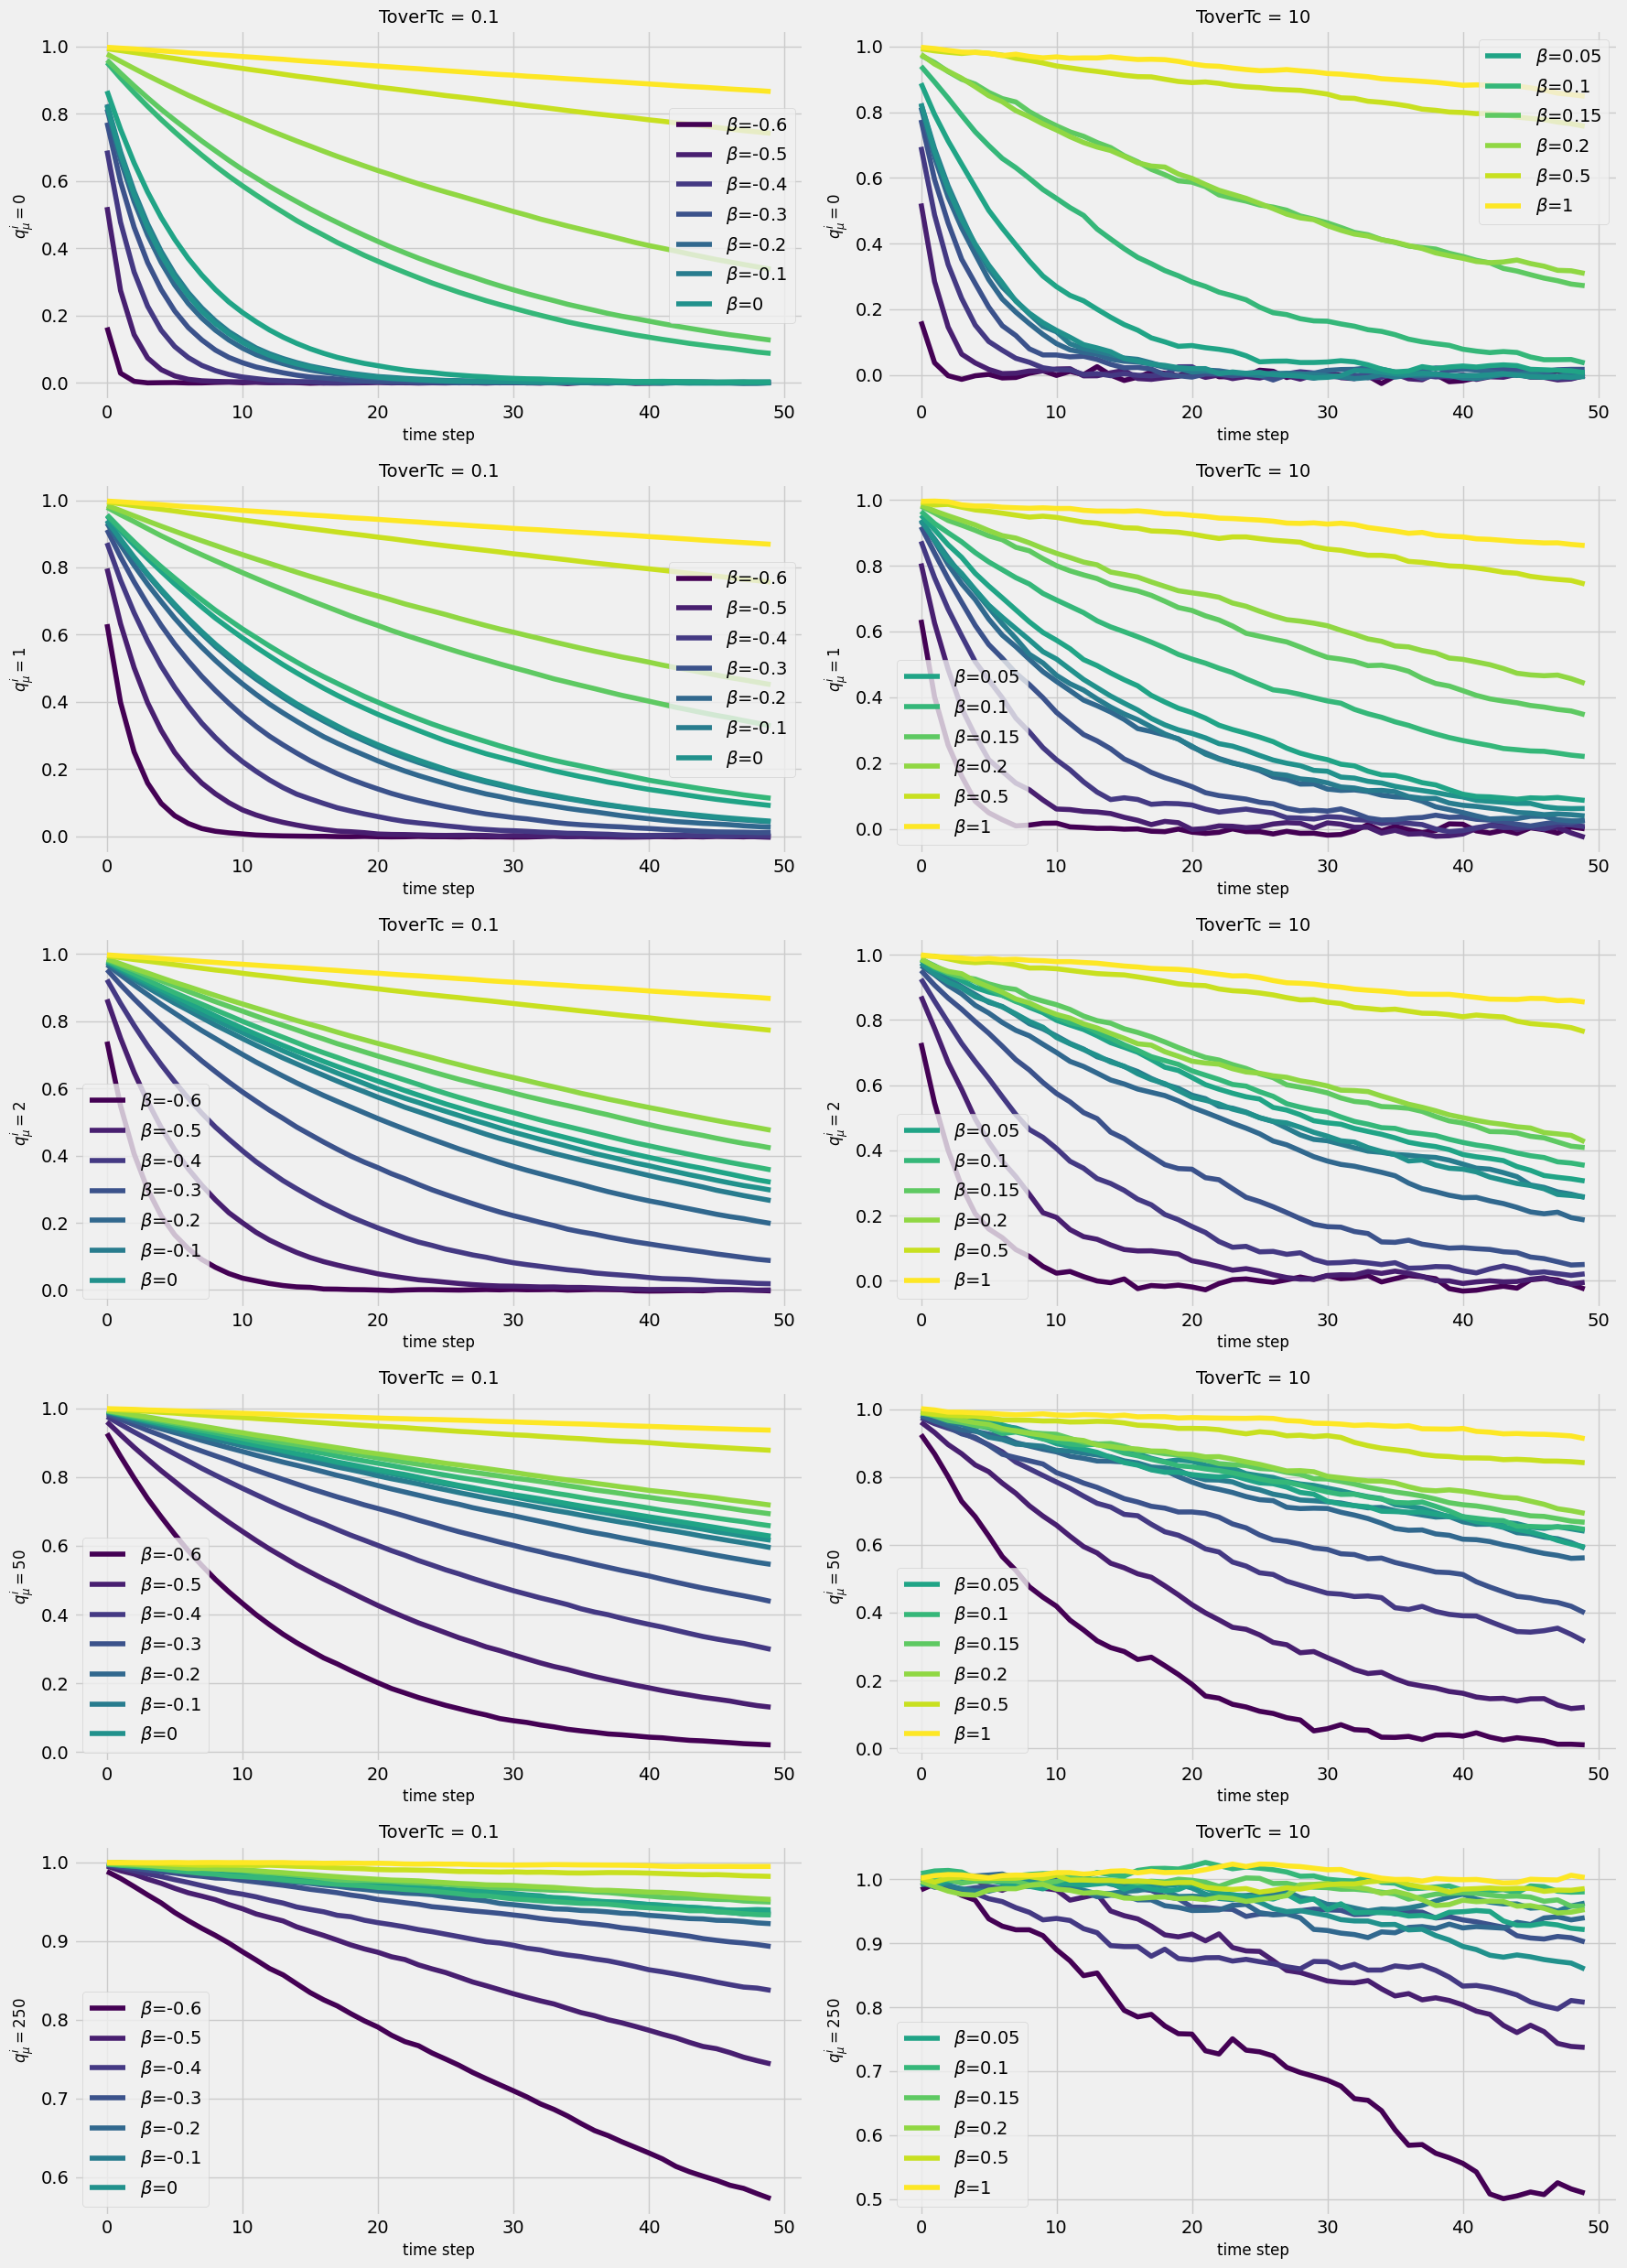

In [6]:
# Create subplots: 3 rows (one for each imu) and 2 columns (for ToverTc values)
fig, axs = plt.subplots(nrows=len(imu_list), ncols=2, figsize=(18, 5 * len(imu_list)))

# Loop over imu values to create rows
for i, imu in enumerate(imu_list):
    # Define a color map for Beta values for each imu
    colors = plt.cm.viridis(np.linspace(0, 1, len(dic_beta_aTc01[imu])))  
    
    # Plot for ToverTc=0.1 in the first column (axs[i, 0])
    ic = 0
    for Beta in dic_beta_aTc01[imu].keys():  # Accessing Beta values for each imu
        dfmu = read_qmu_averaged_realisation(Beta, a0, 0.1, Stocks)
        if Beta<=0:
            axs[i, 0].plot(dfmu[str(imu)].iloc[:50], color=colors[ic], label=r"$\beta$=" + str(Beta))
        else:
            axs[i, 0].plot(dfmu[str(imu)].iloc[:50], color=colors[ic])
        ic += 1

    # Set axis labels and title for ToverTc=0.1
    axs[i, 0].set_xlabel('time step', fontsize=12)
    axs[i, 0].set_ylabel(r'$q_\mu^{i}=$'+str(imu), fontsize=12)
    axs[i, 0].set_title(f'ToverTc = 0.1', fontsize=14)
    axs[i, 0].legend(loc='best')
    axs[i, 0].grid(True)

    # Plot for ToverTc=10 in the second column (axs[i, 1])
    ic = 0
    for Beta in dic_beta_aTc10[imu].keys():  # Accessing Beta values for each imu
        dfmu = read_qmu_averaged_realisation(Beta, a0, 10, Stocks)
        if Beta>0:
            axs[i, 1].plot(dfmu[str(imu)].iloc[:50], color=colors[ic], label=r"$\beta$=" + str(Beta))
        else:
            axs[i, 1].plot(dfmu[str(imu)].iloc[:50], color=colors[ic])
        ic += 1

    # Set axis labels and title for ToverTc=10
    axs[i, 1].set_xlabel('time step', fontsize=12)
    axs[i, 1].set_ylabel(r'$q_\mu^{i}=$'+str(imu), fontsize=12)
    axs[i, 1].set_title(f'ToverTc = 10', fontsize=14)
    axs[i, 1].legend(loc='best')
    axs[i, 1].grid(True)


plt.tight_layout()


plt.savefig('mu_vs_beta_plots.png')


plt.show()

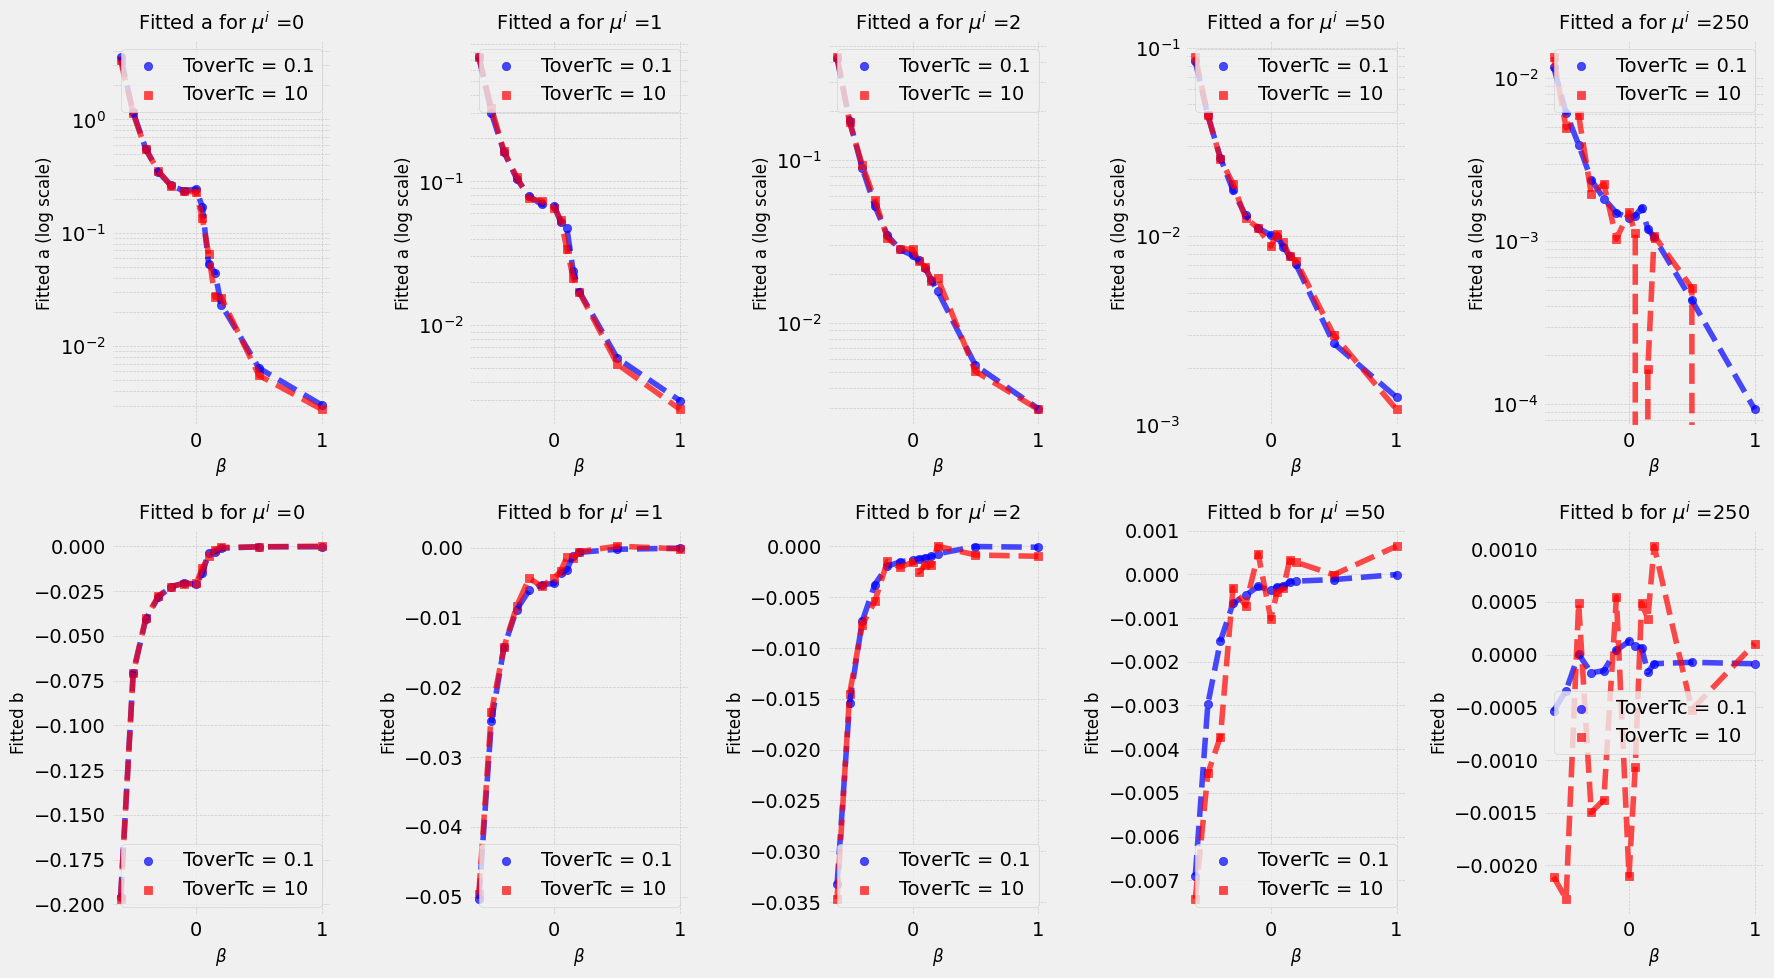

In [7]:
# Create figure with 2 rows and 3 columns for each imu
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(18, 10))

# List of imu values to iterate over
imu_values = [0, 1,2, 50,250]


colors = ['blue', 'red']
markers = ['o', 's']

for i, imu in enumerate(imu_values):
    beta_values = list(dic_beta_aTc01[imu].keys())
    aTc01_values = list(dic_beta_aTc01[imu].values())
    aTc10_values = list(dic_beta_aTc10[imu].values())
    
    bTc01_values = list(dic_beta_bTc01[imu].values())
    bTc10_values = list(dic_beta_bTc10[imu].values())
    
    # Plot a_fitted for both ToverTc values on ax1
    axs[0, i].scatter(beta_values, aTc01_values, label=f'ToverTc = 0.1', color=colors[0], marker=markers[0], alpha=0.7)
    axs[0, i].scatter(beta_values, aTc10_values, label=f'ToverTc = 10', color=colors[1], marker=markers[1], alpha=0.7)
    axs[0, i].plot(beta_values, aTc01_values, color=colors[0], linestyle='--', alpha=0.7)
    axs[0, i].plot(beta_values, aTc10_values, color=colors[1], linestyle='--', alpha=0.7)
    axs[0, i].set_xlabel(r'$\beta$', fontsize=12)
    axs[0, i].set_ylabel('Fitted a (log scale)', fontsize=12)
    axs[0, i].set_title(r'Fitted a for $\mu^{i}$ ='+str(imu), fontsize=14)
    axs[0, i].set_yscale('log')  # Log scale for the a values
    axs[0, i].grid(True, which="both", ls="--", linewidth=0.5)
    axs[0, i].legend(loc='best')
    
    # Plot b_fitted for both ToverTc values on ax2
    axs[1, i].scatter(beta_values, bTc01_values, label=f'ToverTc = 0.1', color=colors[0], marker=markers[0], alpha=0.7)
    axs[1, i].scatter(beta_values, bTc10_values, label=f'ToverTc = 10', color=colors[1], marker=markers[1], alpha=0.7)
    axs[1, i].plot(beta_values, bTc01_values, color=colors[0], linestyle='--', alpha=0.7)
    axs[1, i].plot(beta_values, bTc10_values, color=colors[1], linestyle='--', alpha=0.7)
    axs[1, i].set_xlabel(r'$\beta$', fontsize=12)
    axs[1, i].set_ylabel('Fitted b', fontsize=12)
    axs[1, i].set_title(r'Fitted b for $\mu^{i}$ ='+str(imu), fontsize=14)
    axs[1, i].grid(True, which="both", ls="--", linewidth=0.5)
    axs[1, i].legend(loc='best')


plt.tight_layout()


plt.show()


fig.savefig('a_b_fitted_vs_beta_for_imu.png')

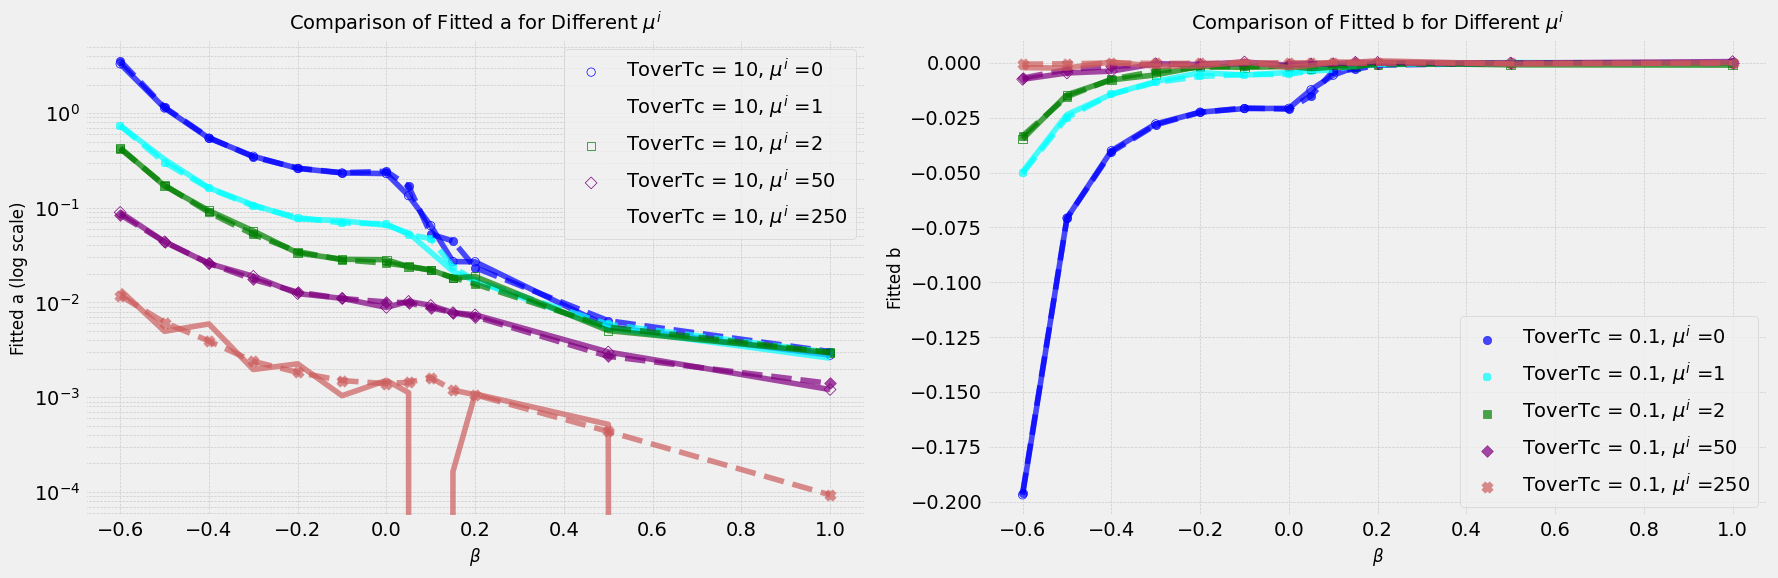

In [8]:
# Create a figure with 1 row and 2 columns for the a_fitted and b_fitted subplots
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Colors and markers for distinct imu values
colors = ['blue', 'cyan','green', 'purple','Indianred']
markers = ['o', '+','s', 'D','x']

for i, imu in enumerate(imu_values):
    # Extract values for each imu
    beta_values = list(dic_beta_aTc01[imu].keys())
    aTc01_values = list(dic_beta_aTc01[imu].values())
    aTc10_values = list(dic_beta_aTc10[imu].values())
    
    bTc01_values = list(dic_beta_bTc01[imu].values())
    bTc10_values = list(dic_beta_bTc10[imu].values())
    
    # Plot a_fitted on ax1 for both ToverTc = 0.1 and ToverTc = 10 for this imu
    ax1.scatter(beta_values, aTc01_values, color=colors[i], marker=markers[i], alpha=0.7)
    ax1.scatter(beta_values, aTc10_values, label=r'ToverTc = 10, $\mu^{i}$ ='+str(imu), color=colors[i], marker=markers[i], facecolors='none', alpha=1)
    ax1.plot(beta_values, aTc01_values, color=colors[i], linestyle='--', alpha=0.7)
    ax1.plot(beta_values, aTc10_values, color=colors[i], linestyle='-', alpha=0.7)
    
    # Plot b_fitted on ax2 for both ToverTc = 0.1 and ToverTc = 10 for this imu
    ax2.scatter(beta_values, bTc01_values, label=r'ToverTc = 0.1, $\mu^{i}$ ='+str(imu), color=colors[i], marker=markers[i], alpha=0.7)
    ax2.scatter(beta_values, bTc10_values, color=colors[i], marker=markers[i], facecolors='none', alpha=1)
    ax2.plot(beta_values, bTc01_values, color=colors[i], linestyle='--', alpha=0.7)
    ax2.plot(beta_values, bTc10_values, color=colors[i], linestyle='-', alpha=0.7)

# Set axis labels, titles, and grid for both subplots
ax1.set_xlabel(r'$\beta$', fontsize=12)
ax1.set_ylabel('Fitted a (log scale)', fontsize=12)
ax1.set_title(r'Comparison of Fitted a for Different $\mu^{i}$', fontsize=14)
ax1.set_yscale('log')  # Log scale for a_fitted
ax1.grid(True, which="both", ls="--", linewidth=0.5)
ax1.legend(loc='best')

ax2.set_xlabel(r'$\beta$', fontsize=12)
ax2.set_ylabel('Fitted b', fontsize=12)
ax2.set_title(r'Comparison of Fitted b for Different $\mu^{i}$', fontsize=14)
ax2.grid(True, which="both", ls="--", linewidth=0.5)
ax2.legend(loc='best')


plt.tight_layout()


plt.show()


fig.savefig('a_b_fitted_vs_beta_for_imu_2col.png')